In [7]:
import mne
mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_3d_backend("notebook")
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
from mne_bids import BIDSPath, read_raw_bids
from itertools import product
from tqdm import tqdm
import os

In [2]:
data_dir = '/mnt/sphere/projects/image_decoding_from_brain/THINGS-MEG-raw/download'
subject_file = data_dir + '/participants.tsv'
subjects = pd.read_csv(subject_file, sep="\t")
def get_subject_id(x):
    return x.split("-")[1]  # noqa
subjects = subjects.participant_id.apply(get_subject_id).values
subject = subjects[0]
tasks = ['main']
sessions = ['{:02d}'.format(x) for x in range(1,13)]  # 2 recording sessions
runs = ['{:02d}'.format(x) for x in range(1,11)]

In [3]:
def clipping(data, n_std = 5):
    a_min = data.mean() - n_std * data.std()
    a_max = data.mean() + n_std * data.std()
    return np.clip(data, a_min, a_max)

In [4]:
mag_ch_names = ['MLC11-1609','MLC12-1609','MLC13-1609','MLC14-1609','MLC15-1609','MLC16-1609','MLC17-1609','MLC21-1609','MLC22-1609','MLC23-1609','MLC24-1609','MLC25-1609','MLC31-1609','MLC32-1609','MLC41-1609','MLC42-1609','MLC51-1609','MLC52-1609','MLC53-1609','MLC54-1609','MLC55-1609','MLC61-1609','MLC62-1609','MLC63-1609',
 'MLF11-1609','MLF12-1609','MLF13-1609','MLF14-1609','MLF21-1609','MLF22-1609','MLF23-1609','MLF24-1609','MLF31-1609','MLF32-1609','MLF33-1609','MLF34-1609','MLF35-1609','MLF41-1609','MLF42-1609','MLF43-1609','MLF44-1609','MLF45-1609','MLF46-1609','MLF51-1609','MLF52-1609','MLF53-1609','MLF54-1609','MLF55-1609','MLF56-1609','MLF61-1609','MLF62-1609','MLF63-1609','MLF64-1609','MLF65-1609','MLF66-1609','MLF67-1609',
 'MLO11-1609','MLO12-1609','MLO13-1609','MLO14-1609','MLO21-1609','MLO22-1609','MLO23-1609','MLO24-1609','MLO31-1609','MLO32-1609','MLO33-1609','MLO34-1609','MLO41-1609','MLO42-1609','MLO43-1609','MLO44-1609','MLO51-1609','MLO52-1609','MLO53-1609',
 'MLP11-1609','MLP12-1609','MLP21-1609','MLP22-1609','MLP23-1609','MLP31-1609','MLP32-1609','MLP33-1609','MLP34-1609','MLP35-1609','MLP41-1609','MLP42-1609','MLP43-1609','MLP44-1609','MLP45-1609','MLP51-1609','MLP52-1609','MLP53-1609','MLP54-1609','MLP55-1609','MLP56-1609','MLP57-1609',
 'MLT11-1609','MLT12-1609','MLT13-1609','MLT14-1609','MLT15-1609','MLT16-1609','MLT21-1609','MLT22-1609','MLT23-1609','MLT24-1609','MLT25-1609','MLT26-1609','MLT27-1609','MLT31-1609','MLT32-1609','MLT33-1609','MLT34-1609','MLT35-1609','MLT36-1609','MLT37-1609','MLT41-1609','MLT42-1609','MLT43-1609','MLT44-1609','MLT45-1609','MLT46-1609','MLT47-1609','MLT51-1609','MLT52-1609','MLT53-1609','MLT54-1609','MLT55-1609','MLT56-1609','MLT57-1609',
 'MRC11-1609','MRC12-1609','MRC13-1609','MRC14-1609','MRC15-1609','MRC16-1609','MRC17-1609','MRC21-1609','MRC22-1609','MRC23-1609','MRC24-1609','MRC25-1609','MRC31-1609','MRC32-1609','MRC41-1609','MRC42-1609','MRC51-1609','MRC52-1609','MRC53-1609','MRC54-1609','MRC55-1609','MRC61-1609','MRC62-1609','MRC63-1609',
 'MRF11-1609','MRF12-1609','MRF13-1609','MRF14-1609','MRF21-1609','MRF22-1609','MRF23-1609','MRF24-1609','MRF25-1609','MRF31-1609','MRF32-1609','MRF33-1609','MRF34-1609','MRF35-1609','MRF41-1609','MRF42-1609','MRF44-1609','MRF45-1609','MRF46-1609','MRF51-1609','MRF52-1609','MRF53-1609','MRF54-1609','MRF55-1609','MRF56-1609','MRF61-1609','MRF62-1609','MRF63-1609','MRF64-1609','MRF65-1609','MRF66-1609','MRF67-1609',
 'MRO11-1609','MRO12-1609','MRO14-1609','MRO21-1609','MRO22-1609','MRO23-1609','MRO24-1609','MRO31-1609','MRO32-1609','MRO33-1609','MRO34-1609','MRO41-1609','MRO42-1609','MRO43-1609','MRO44-1609','MRO51-1609','MRO52-1609','MRO53-1609',
 'MRP11-1609', 'MRP12-1609', 'MRP21-1609', 'MRP22-1609', 'MRP23-1609', 'MRP31-1609', 'MRP32-1609', 'MRP33-1609', 'MRP34-1609', 'MRP35-1609', 'MRP41-1609', 'MRP42-1609', 'MRP43-1609', 'MRP44-1609', 'MRP45-1609', 'MRP51-1609', 'MRP52-1609', 'MRP53-1609', 'MRP54-1609', 'MRP55-1609', 'MRP56-1609','MRP57-1609',
 'MRT11-1609', 'MRT12-1609', 'MRT13-1609', 'MRT14-1609', 'MRT15-1609', 'MRT16-1609', 'MRT21-1609', 'MRT22-1609', 'MRT23-1609', 'MRT24-1609', 'MRT25-1609', 'MRT26-1609', 'MRT27-1609', 'MRT31-1609', 'MRT32-1609', 'MRT33-1609', 'MRT34-1609', 'MRT35-1609', 'MRT36-1609', 'MRT37-1609', 'MRT41-1609', 'MRT42-1609', 'MRT43-1609', 'MRT44-1609', 'MRT45-1609', 'MRT46-1609', 'MRT47-1609', 'MRT51-1609', 'MRT52-1609', 'MRT53-1609', 'MRT54-1609', 'MRT55-1609', 'MRT56-1609', 'MRT57-1609',
 'MZC01-1609', 'MZC02-1609', 'MZC03-1609', 'MZC04-1609',
 'MZF01-1609','MZF02-1609','MZF03-1609',
 'MZO01-1609','MZO02-1609','MZO03-1609',
 'MZP01-1609']
ch_type_map = {'UPPT001': 'stim'}
ch_type_map.update({x: 'mag' for x in mag_ch_names})

In [5]:
train_meg = None
test_meg = None
for session, task, run in tqdm(product(sessions, tasks, runs), total=len(sessions)*len(tasks)*len(runs)):
    bids_path = BIDSPath(
        subject=subject,
        session=session,
        task=task,
        root=data_dir,
        run = run,
        datatype="meg",
    )
    raw = read_raw_bids(bids_path, verbose='ERROR')
    raw.set_channel_types(ch_type_map, verbose='ERROR')
    events, event_dict = mne.events_from_annotations(raw, verbose='ERROR')
    epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.3, tmax=1.0, baseline=(-0.3, 0), preload=True, picks='mag', verbose='ERROR').resample(120, npad="auto", verbose='ERROR')
    epochs.crop(tmin=0.0, tmax=epochs.tmax, verbose=False);
    epochs.filter(0, 40, verbose=False);
    epochs.apply_function(clipping, n_std = 5, verbose=False);
    if train_meg is None:
        train_meg = epochs['exp'].get_data(copy=True)
        test_meg = epochs['test'].get_data(copy=True)
    else:
        train_meg = np.concatenate((train_meg, epochs['exp'].get_data(copy=True)), axis=0)
        test_meg = np.concatenate((test_meg, epochs['test'].get_data(copy=True)), axis=0)
    # break
# bids_path

 41%|████      | 49/120 [43:48<1:03:28, 53.64s/it]


KeyboardInterrupt: 

In [6]:
train_meg.shape, test_meg.shape

((9085, 272, 120), (980, 272, 120))

In [13]:
save_dir = 'cache/processed_data/' + subject + '/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
np.save(save_dir + f'train_thingsmeg_sub-{subject}.npy', train_meg)
np.save(save_dir + f'test_thingsmeg_sub-{subject}.npy', test_meg)

In [12]:
f'train_thingsmeg_sub-{subject}.npy'

'train_thingsmeg_sub-BIGMEG1.npy'

In [6]:
ch_type_map = {'UPPT001': 'stim'}
ch_type_map.update({x: 'mag' for x in mag_ch_names})

In [7]:
raw.set_channel_types(ch_type_map)

/tmp/ipykernel_3203178/1938683839.py:1: RuntimeWarning: The unit for channel(s) UPPT001 has changed from NA to V.
  raw.set_channel_types(ch_type_map)
/tmp/ipykernel_3203178/1938683839.py:1: RuntimeWarning: The unit for channel(s) MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, MLC16-1609, MLC17-1609, MLC21-1609, MLC22-1609, MLC23-1609, MLC24-1609, MLC25-1609, MLC31-1609, MLC32-1609, MLC41-1609, MLC42-1609, MLC51-1609, MLC52-1609, MLC53-1609, MLC54-1609, MLC55-1609, MLC61-1609, MLC62-1609, MLC63-1609, MLF11-1609, MLF12-1609, MLF13-1609, MLF14-1609, MLF21-1609, MLF22-1609, MLF23-1609, MLF24-1609, MLF31-1609, MLF32-1609, MLF33-1609, MLF34-1609, MLF35-1609, MLF41-1609, MLF42-1609, MLF43-1609, MLF44-1609, MLF45-1609, MLF46-1609, MLF51-1609, MLF52-1609, MLF53-1609, MLF54-1609, MLF55-1609, MLF56-1609, MLF61-1609, MLF62-1609, MLF63-1609, MLF64-1609, MLF65-1609, MLF66-1609, MLF67-1609, MLO11-1609, MLO12-1609, MLO13-1609, MLO14-1609, MLO21-1609, MLO22-1609, MLO23-1609, MLO24-1609, M

Measurement date,"June 13, 2019 00:00:00 GMT"
Experimenter,mne_anonymize
Participant,sub-BIGMEG1
Digitized points,3 points
Good channels,"9 misc, 28 Reference Magnetometers, 272 Magnetometers, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1200.00 Hz
Highpass,0.00 Hz
Lowpass,600.00 Hz


Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


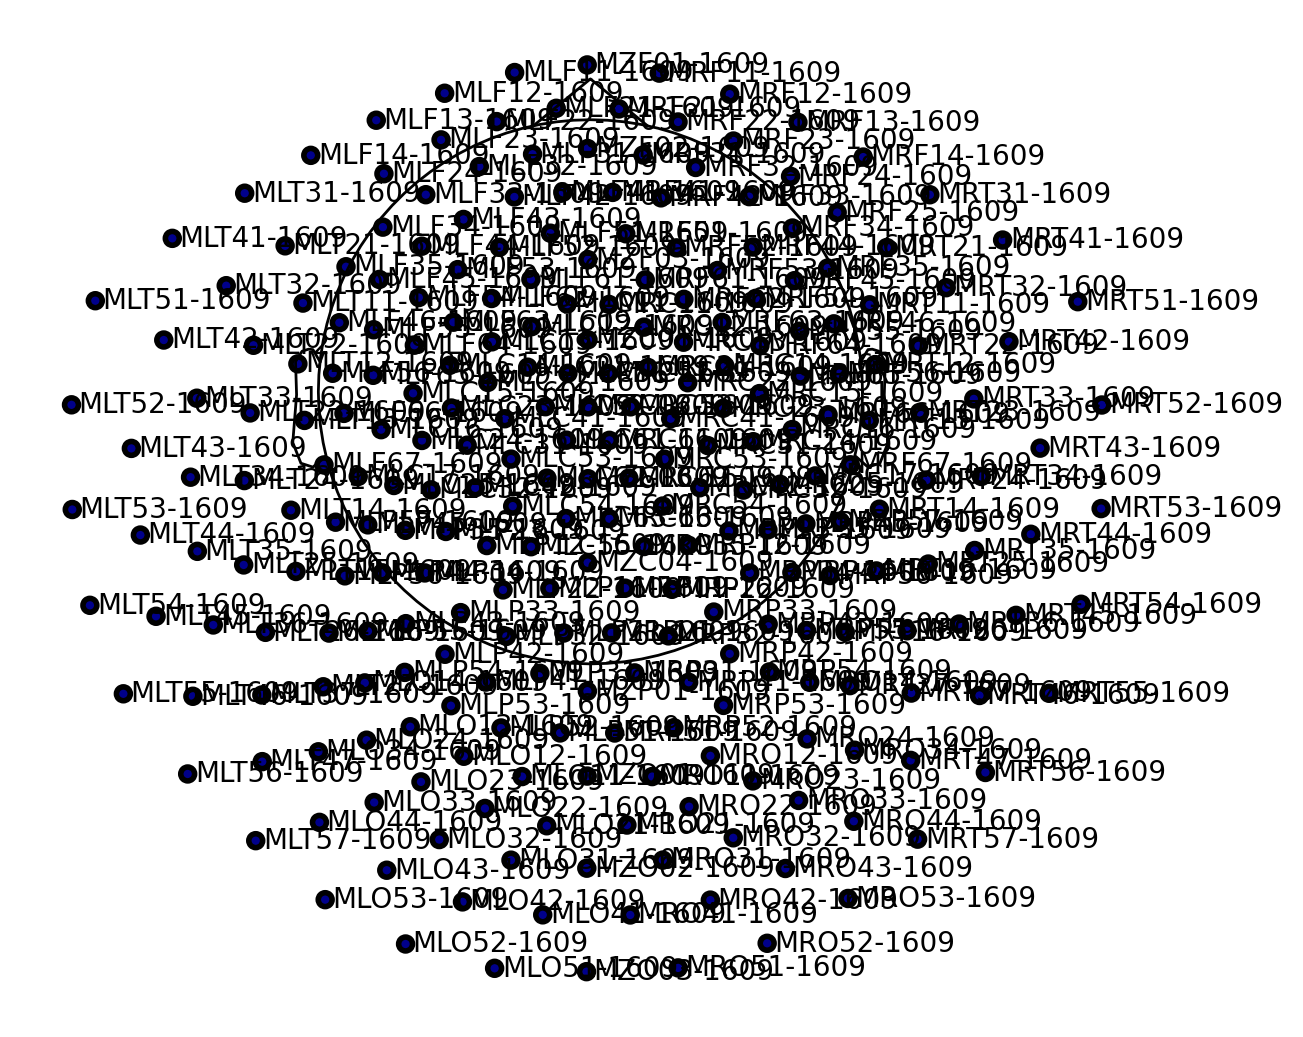

In [8]:
raw.plot_sensors(kind='topomap', ch_type= 'mag', show_names=True);

In [16]:
events, event_dict = mne.events_from_annotations(raw)

Used Annotations descriptions: ['catch', 'exp/10046.0', 'exp/1014.0', 'exp/10216.0', 'exp/10271.0', 'exp/1042.0', 'exp/10869.0', 'exp/11027.0', 'exp/11145.0', 'exp/11379.0', 'exp/11745.0', 'exp/11837.0', 'exp/11900.0', 'exp/12115.0', 'exp/12130.0', 'exp/12342.0', 'exp/12389.0', 'exp/12401.0', 'exp/12419.0', 'exp/12791.0', 'exp/12889.0', 'exp/12901.0', 'exp/12941.0', 'exp/13129.0', 'exp/13167.0', 'exp/1329.0', 'exp/13595.0', 'exp/13610.0', 'exp/13695.0', 'exp/13834.0', 'exp/13874.0', 'exp/14029.0', 'exp/14257.0', 'exp/14269.0', 'exp/14424.0', 'exp/14569.0', 'exp/14744.0', 'exp/14811.0', 'exp/15050.0', 'exp/15245.0', 'exp/16202.0', 'exp/16290.0', 'exp/16327.0', 'exp/16495.0', 'exp/16568.0', 'exp/16808.0', 'exp/16838.0', 'exp/16926.0', 'exp/1704.0', 'exp/17387.0', 'exp/17420.0', 'exp/17435.0', 'exp/17462.0', 'exp/17541.0', 'exp/17624.0', 'exp/1807.0', 'exp/18206.0', 'exp/1835.0', 'exp/18416.0', 'exp/18595.0', 'exp/18627.0', 'exp/18706.0', 'exp/18855.0', 'exp/19142.0', 'exp/19156.0', 'exp/

In [118]:
def clipping(data, n_std = 5):
    # sem = data.std() / np.sqrt(len(data)) # standard error of the mean
    # sem = data.std() / np.sqrt(1)
    # a_min = data.mean() - n_sem * sem
    # a_max = data.mean() + n_sem * sem
    a_min = data.mean() - n_std * data.std()
    a_max = data.mean() + n_std * data.std()
    return np.clip(data, a_min, a_max)

In [121]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.3, tmax=1.0, baseline=(-0.3, 0), preload=True, picks='mag').resample(120, npad="auto")
epochs.crop(tmin=0.0, tmax=epochs.tmax, verbose=False);
# epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=0.0, tmax=1.0, baseline=None, detrend=0, preload=True, picks='mag').resample(120, npad="auto")
# epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=0.0, tmax=1.0, baseline=(0, 0.5), preload=True, picks='mag').resample(120, npad="auto")
epochs.filter(0, 40, verbose=False);
epochs.apply_function(clipping, n_std = 5, verbose=False);

Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 226 events and 1561 original time points ...
0 bad epochs dropped


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


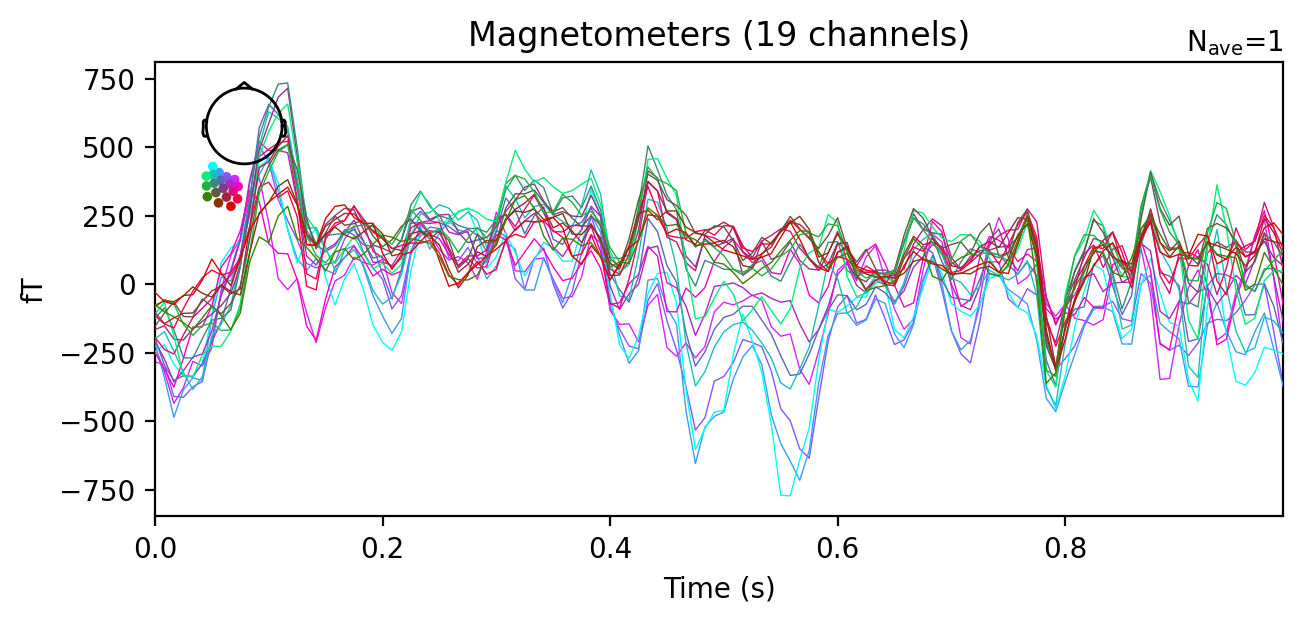

In [122]:
epochs[1].pick_channels(mag_ch_names[56:75]).average().plot();

In [28]:
epochs.info["sfreq"]

120.0

In [123]:
epochs['exp'].get_data(copy=True).shape, epochs['test'].get_data(copy=True).shape

((186, 272, 120), (20, 272, 120))

In [116]:
# epochs['exp'].pick_channels(mag_ch_names[56:75]).average().plot();

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Removing 5 compensators from info because not all compensation channels were picked.
Effective window size : 1.707 (s)


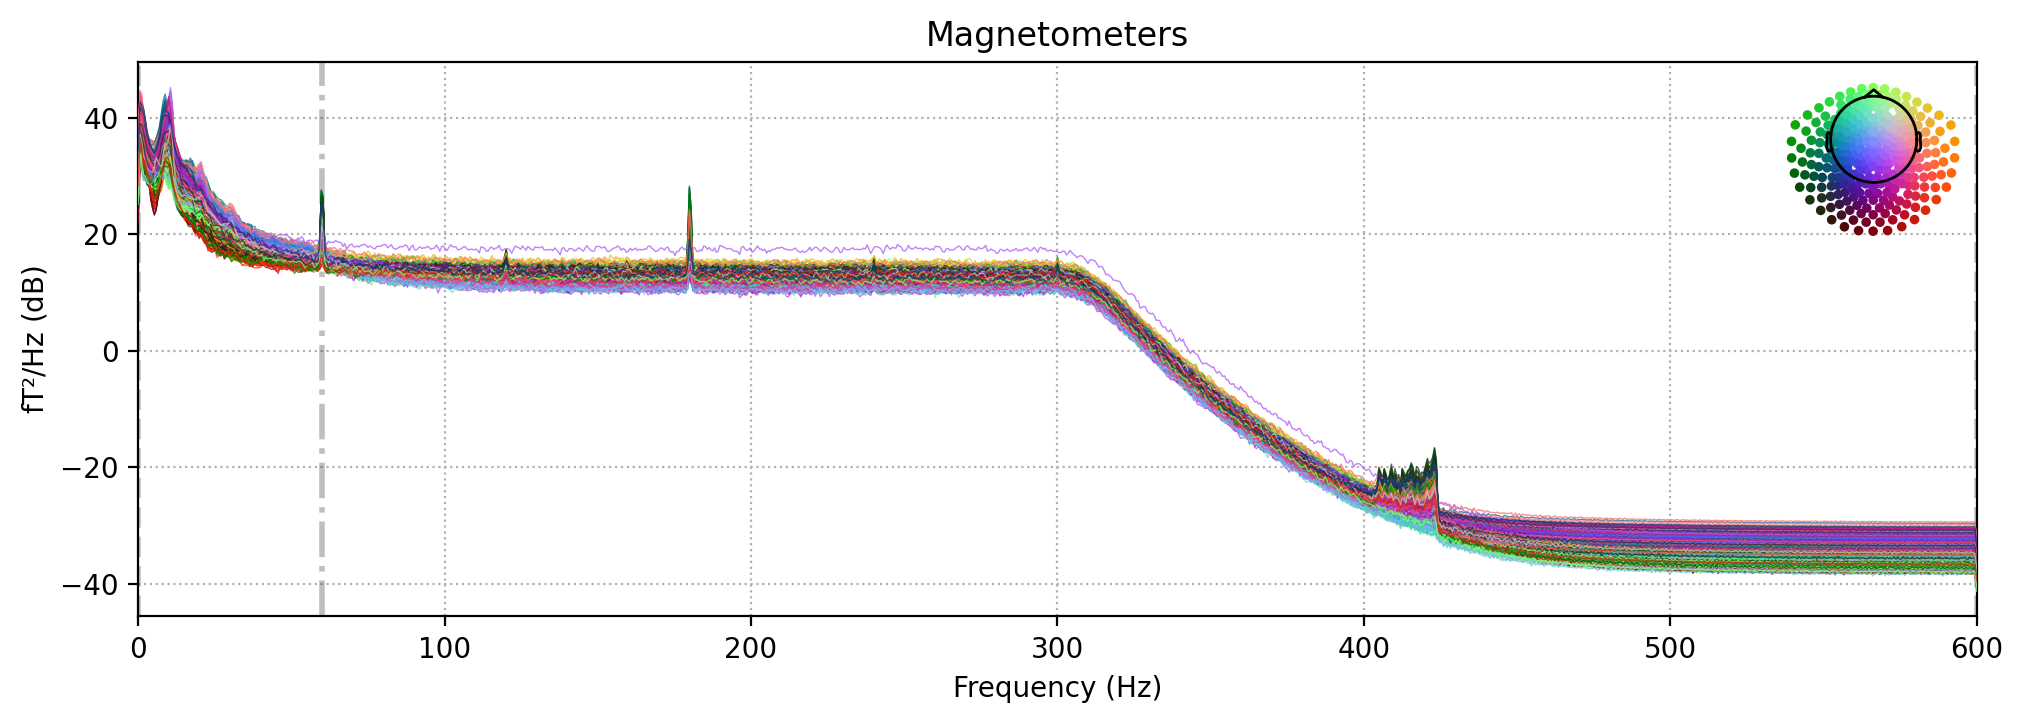

In [37]:
raw.plot_psd();

In [55]:
# dict(zip(mag_ch_names, range(len(mag_ch_names))))

In [70]:
epochs['exp'].get_data(copy=True)

array([[[-3.94997689e-15, -1.76134622e-14, -9.51425033e-15, ...,
          8.05010740e-14,  1.56068677e-13,  1.98879384e-13],
        [-1.32369022e-14, -5.04963594e-14, -5.71453925e-14, ...,
          3.71803535e-14,  1.13621686e-13,  1.20534504e-13],
        [ 9.21488832e-14, -2.47504129e-14, -2.83422215e-14, ...,
          3.54712445e-14,  1.52193530e-13,  1.62828232e-13],
        ...,
        [-1.50215727e-13, -6.31266372e-14,  1.03435583e-13, ...,
          1.87133065e-13,  1.06472397e-13,  7.32719420e-14],
        [ 1.11443784e-14,  3.52421229e-15,  3.28521194e-14, ...,
          2.50070888e-13,  2.32279611e-13,  1.19670710e-13],
        [-3.68749962e-13, -2.37070155e-13, -3.26428940e-14, ...,
          1.25982665e-13,  2.13666363e-14, -9.76778534e-14]],

       [[ 6.01412331e-14,  1.87263306e-13,  2.38529675e-13, ...,
          3.04678818e-13,  2.24527634e-13,  2.44231487e-13],
        [-1.59276304e-14,  9.18593268e-14,  6.93628993e-14, ...,
          3.46041817e-13,  2.11582034e